# Sentiment analysis on IMDB reviews: TensorFlow GloVe and LSTM with Estimator APIs

In this notebook I will try to perform sentiment analysis using TensorFlow. Most of the notebook is a variation of what was done on this blog:
https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow

This is an upgrade of the previous notebook (IMDB_sent_an_TF_basic_improved1) where I'm replacing the basic APIs by custom Estimator level APIs. For this I follow the indications of these tutorial:

https://www.tensorflow.org/get_started/premade_estimators

https://www.tensorflow.org/get_started/datasets_quickstart

https://www.tensorflow.org/get_started/custom_estimators


## Libraries

In [1]:
import numpy as np
import csv
import io
import tensorflow as tf
import datetime

## Loading pretrained embeddings

The pretrained embeddins from GloVe can be downloaded here: https://nlp.stanford.edu/projects/glove/

In this notebook, I use the smallest ones, i.e. the ones where the word embedding vectors are of length 50.

In [2]:
#emb_file_name = 'glove.6B/glove.6B.50d_toy.txt' #toy embeddings with only the
                                                #three first rows (instead of 4K)
emb_file_name = 'glove.6B/glove.6B.50d.txt'

The code of the next cell comes from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python#45894001

In [3]:
import pandas as pd
import csv

emb_df = pd.read_table(emb_file_name, sep=" ",
                       index_col=0, header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')

In [4]:
emb_df.shape

(400000, 50)

Then we transform the Pandas data frame into one list containing the words (the indexes from the data frame) and one numpy array containing the corresponding vectors. This last data frame will play the role of our **look-up table** later when we define our model.

In [5]:
wordsList = list(emb_df.index)
wordVectors = emb_df.values

## Examples with Embeddings

I commented this part because it is useless for the real task. It only serves a pedagogic purpose.

In [6]:
#baseballIndex = wordsList.index('baseball')
#wordVectors[baseballIndex]

In [7]:
#maxSeqLength = 10 #Maximum length of sentence

In [8]:
#firstSentence = np.zeros((maxSeqLength), dtype='int32')
#firstSentence[0] = wordsList.index("i")
#firstSentence[1] = wordsList.index("thought")
#firstSentence[2] = wordsList.index("the")
#firstSentence[3] = wordsList.index("movie")
#firstSentence[4] = wordsList.index("was")
#firstSentence[5] = wordsList.index("incredible")
#firstSentence[6] = wordsList.index("and")
#firstSentence[7] = wordsList.index("inspiring")
##firstSentence[8] and firstSentence[9] are going to be 0
#print(firstSentence.shape)
#print(firstSentence) #Shows the row index for each word

In [9]:
#with tf.Session() as sess:
#    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

## Visualizing the data

In this section we are looking for the threshold we should take as maximum length of a text.

In [10]:
from os import listdir
from os.path import isfile, join

In [11]:
PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb/"
#PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb_sample2/"
TRAIN = PATH+'train/'
TEST = PATH+'test/'

In [12]:
TRAIN_POS = TRAIN + 'pos/'
TRAIN_NEG = TRAIN + 'neg/'
positiveFilesTrain = [TRAIN_POS + f for f in listdir(TRAIN_POS) if isfile(join(TRAIN_POS, f))]
negativeFilesTrain = [TRAIN_NEG + f for f in listdir(TRAIN_NEG) if isfile(join(TRAIN_NEG, f))]

In [13]:
TEST_POS = TEST + 'pos/'
TEST_NEG = TEST + 'neg/'
positiveFilesTest = [TEST_POS + f for f in listdir(TEST_POS) if isfile(join(TEST_POS, f))]
negativeFilesTest = [TEST_NEG + f for f in listdir(TEST_NEG) if isfile(join(TEST_NEG, f))]

Next we determine the average number of words in one sample of the training set.

In [14]:
numWords = []
for pf in positiveFilesTrain:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFilesTrain:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

Positive files finished
Negative files finished


In [15]:
numFilesTrain = len(positiveFilesTrain) + len(negativeFilesTrain)
numFilesTest = len(positiveFilesTest) + len(negativeFilesTest)

Strangely it seems that there aren't exactly 12500 files in the folders indicated below, as it is supposed to be.

In [16]:
print(len(positiveFilesTrain))
print(len(negativeFilesTrain))
print(len(positiveFilesTest))
print(len(negativeFilesTest))

12501
12501
12501
12500


In [17]:
print('The total number of files is', numFilesTrain)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is 25002
The total number of words in the files is 5844682
The average number of words in the files is 233.7685785137189


Next we plot an histogram of the number of words in each sample.

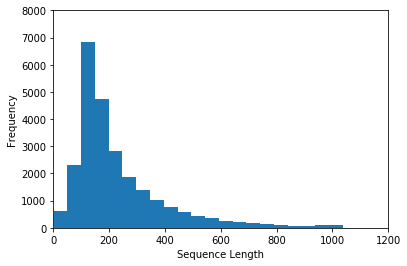

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Looking at this, 250 words seems a good choice.

In [19]:
maxSeqLength = 250

## Mapping words to indexes

In this section we map words to indexes using our wordsList variable.

First we do it for a specific file (I commented this part because it is useless for the real task).

In [20]:
#fname = positiveFilesTrain[3] #Can use any valid index (not just 3)
#with open(fname) as f:
#    for lines in f:
#        print(lines)
#        exit

Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters

In [21]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [22]:
#firstFile = np.zeros((maxSeqLength), dtype='int32')
#with open(fname) as f:
#    indexCounter = 0
#    line=f.readline()
#    cleanedLine = cleanSentences(line)
#    split = cleanedLine.split()
#    for word in split:
#        try:
#            firstFile[indexCounter] = wordsList.index(word)
#        except ValueError:
#            firstFile[indexCounter] = 399999 #Vector for unknown words
#        indexCounter = indexCounter + 1
#firstFile

### Training set

ids_train will be a matrix, which contains for each file of the training set (first the positive ones, then the negative ones) a row where the columns contain the indices corresponding to the words of the sample file.

The whole computation of the transformation of each text file into a list of indices takes time and needs to be performed only once. The result is saved after the first time and then reloaded for all the other executions.

In [23]:
#ids_train = np.zeros((numFilesTrain, maxSeqLength), dtype='int32')

In [24]:
#fileCounter = 0
#for pf in positiveFilesTrain:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids_train[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids_train[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1

In [25]:
#for nf in negativeFilesTrain:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids_train[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids_train[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

In [26]:
#Pass into embedding function and see if it evaluates. 

#np.save('idsMatrixTrain', ids_train)

ids_train = np.load('idsMatrixTrain.npy')

We create some toy data to be able to perform quick sanity check.

In [27]:
ids_train_toy = ids_train[12400:12600]

### Testing set

In [28]:
#ids_test = np.zeros((numFilesTest, maxSeqLength), dtype='int32')

In [29]:
#fileCounter = 0
#for pf in positiveFilesTest:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids_test[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids_test[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1

In [30]:
#for nf in negativeFilesTest:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids_test[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids_test[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

In [31]:
#np.save('idsMatrixTest', ids_test)

ids_test = np.load('idsMatrixTest.npy')

## Labels

Now we also create the **labels** with **one-hot-encoding** ([1, 0] for positive and [0, 1] for negative), as done in the original notebook.

In [32]:
lenPosTrain = len(positiveFilesTrain)
lenNegTrain = len(negativeFilesTrain)
y_train = [[1,0] for i in range(lenPosTrain)] + [[0,1] for i in range(lenNegTrain)]

In [33]:
lenPosTest = len(positiveFilesTest)
lenNegTest = len(negativeFilesTest)
y_test = [[1,0] for i in range(lenPosTest)] + [[0,1] for i in range(lenNegTest)]

We create the labels for the toy data.

In [34]:
y_train_toy = y_train[12400:12600]

It seems that some premade estimators do not accept one-hot-encoding of the labels as explained here:https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change

For this reason I create a function which converts a list containing one-hot-incoded labels into a list containing **ordinal encoded** labels.

In [35]:
def oneHot2Ordinal(oneHot):
    n_classes = len(oneHot[0])
    ordinal = []
    for i in range(len(oneHot)):
        for j in range(n_classes):
            if oneHot[i][j]==1:
                ordinal.append(j)
    return(ordinal)

In [36]:
y_train_toy_ord = oneHot2Ordinal(y_train_toy)
print(len(y_train_toy_ord))
print(y_train_toy_ord[0])

200
0


In [37]:
y_train_ord = oneHot2Ordinal(y_train)
y_test_ord = oneHot2Ordinal(y_test)

## Definition of the model

### Estimator APIs

In this section we create a model using the Estimator APIs from TF.

First we define the **input functions**. They are the objects which supply data for training, evaluating, and prediction to the model.

In [38]:
# features is a numpy array of shape (#samples, 250)
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(({'Indexes':features}, labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    
    return dataset

In [39]:
# features is a numpy array of shape (#samples, 250)
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    if labels is None:
        # No labels, use only features.
        inputs = {'Indexes':features}
    else:
        inputs = ({'Indexes':features}, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    return dataset

Next we define the **feature columns**:

In [40]:
my_feature_columns = []
my_feature_columns.append(tf.feature_column.numeric_column(key='Indexes', shape=maxSeqLength))

Next we define the directory where to store the log files for TensorBoard.

In [41]:
model_dir = '/home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/'

In order to define a custom estimator we need to define a **model function**. For this we mix the code of the notebook based only on basic TF APIs together with some parts of the script of this tutorial: https://www.tensorflow.org/get_started/custom_estimators

In [42]:
def my_model(features, labels, mode, params):
    # Use `input_layer` to apply the feature columns.
    input_data = tf.feature_column.input_layer(features, params['feature_columns'])
    # The next line is required because tf.feature_column.input_layer
    # outputs tf.float32 (whatever the input)
    # and tf.nn.embedding_lookup requires
    # tf.int32
    input_data = tf.cast(input_data, tf.int32)
    # Transform each index in a sentence into the associated vector
    data = tf.nn.embedding_lookup(wordVectors, input_data)
    # The following line is a fixe coming from this page:
    # https://github.com/tgjeon/TensorFlow-Tutorials-for-Time-Series/issues/2
    # in order to prevent an error appearing next.
    data = tf.cast(data, tf.float32)
    # Next we define the LSTM
    lstmCell = tf.contrib.rnn.BasicLSTMCell(params['lstmUnits'])
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=params['keep_prob'])
    value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)
    # swaps the two first dimensions so it has dimensions [max_time, batch_size, cell.output_size]
    value = tf.transpose(value, [1, 0, 2])
    # If I'm not mistaken the next cell slices the part of 
    # the output which corresponds to the last output of the lstm, 
    # or in other words the output corresponding to the 
    # last word for every sample (if I'm right we used 
    # 0 padding and cut everything which goes beyound 250 words, 
    # so technically it is the 250th output). 
    # My guess is that last has dimensions [batch_size, cell.output_size] 
    # which we can then use to do matrix multiplication 
    # with weight which has dimensions [cell.output_size, numClasses] 
    # (remember that cell.output_size=lstmUnits).
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    # We apply an affine transformation to get the logits
    weight = tf.Variable(tf.truncated_normal([params['lstmUnits'], params['n_classes']]))
    bias = tf.Variable(tf.constant(0.1, shape=[params['n_classes']]))
    logits = (tf.matmul(last, weight) + bias)
    # Maybe I could  replace this last part using tf.layers.dense:
    # https://www.tensorflow.org/api_docs/python/tf/layers/dense
    
    # The following lines are actually independent of the achitecture
    # of the model.
    
    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
# TensorBoard 1 (method original Notebook)
    
#    correctPred = tf.equal(tf.argmax(predicted_classes,1), tf.argmax(labels,1))
#    accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
#    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_classes, labels=labels))
#    tf.summary.scalar('Loss', loss)
#    tf.summary.scalar('Accuracy', accuracy)

#TensorBoard 2 (method TF tutorial)
    
    # Compute loss
    
    # Note that because of this function, we have to
    # provide ordinaly encoded labels and not one-hot-encoded
    # labels, as explained on this page:
    # https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy[1])
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)
    
    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

Next we can define the **custom estimator**.

In [43]:
classifier = tf.estimator.Estimator(
        model_fn=my_model,
        model_dir=model_dir,
        params={
            'feature_columns': my_feature_columns,
            'n_classes': 2,
            'lstmUnits': 64,
            'keep_prob': 0.8
        })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_is_chief': True, '_log_step_count_steps': 100, '_task_type': 'worker', '_service': None, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_master': '', '_task_id': 0, '_evaluation_master': '', '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_save_summary_steps': 100, '_model_dir': '/home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/', '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5e5f36ada0>, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5}


## Training and evaluation of the Estimator

In [45]:
batch_size = int(32)
train_steps = int(500)

Now we can **train** our Estimator. Note that for the premade estimator that we are using requires the label to be ordinaly encoded and not one-hot-encoded as explained here:

https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change

In [46]:
classifier.train(
    input_fn=lambda:train_input_fn(features=ids_train, labels=y_train_ord, batch_size=batch_size),
    steps=train_steps)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


/home/aritz/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/model.ckpt.
INFO:tensorflow:loss = 0.749625, step = 0
INFO:tensorflow:global_step/sec: 6.945
INFO:tensorflow:loss = 0.0, step = 100 (14.400 sec)
INFO:tensorflow:global_step/sec: 7.53953
INFO:tensorflow:loss = 0.0, step = 200 (13.263 sec)
INFO:tensorflow:global_step/sec: 7.55014
INFO:tensorflow:loss = 0.0, step = 300 (13.245 sec)
INFO:tensorflow:global_step/sec: 7.48705
INFO:tensorflow:loss = 0.65994954, step = 400 (13.356 sec)
INFO:tensorflow:Saving checkpoints for 500 into /home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/model.ckpt.
INFO:tensorflow:Loss for final step: 0.005850534.


Now we can evaluate our model on the test data.

In [47]:
evaluation_test = classifier.evaluate(input_fn=lambda:eval_input_fn(features=ids_test,
                                                                    labels=y_test_ord,
                                                                    batch_size=batch_size)
                                     )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-08-20:05:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-08-20:06:10
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.49998, global_step = 500, loss = 2.6552541


## TensorBoard

The author of the tutorial also mentions the possibility of tracking the progress of the model on TensorBoard by entering "tensorboard --logdir=(...)" in a terminal with "(...)" replaced by the name of the directory where the event files are saved, and visiting http://localhost:6006/ with a browser.

## Basic APIs

In this section we present the original implementation of the model, relying on TF basic APIs. It will be replaced by estimators APIs.

In [ ]:
batchSize = 24
lstmUnits = 64
numClasses = 2

In [ ]:
import tensorflow as tf
tf.reset_default_graph()

These placeholders are here to take the input of the model (labels and samples turned into arrays of indices).

In [ ]:
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

Then we embed the indices into vectors. The next cell is commented out because I think that it is useless. It was in the tutorial but I suspect that its author forgot to remove it.
As explained in the tutorial, we were using pretrained embeddings where vectors have length 50. But here numDimensions are of length 300. And in the following cell, 'data' defined again... I ran the notebook with and without it and it gives similar results so I commented it out.

In [ ]:
#data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)

In [ ]:
data = tf.nn.embedding_lookup(wordVectors, input_data)

The following cell is a fix comming from
https://github.com/tgjeon/TensorFlow-Tutorials-for-Time-Series/issues/2
If I don't put it, errors appear in the cell after this one.

In [ ]:
data = tf.cast(data, tf.float32)

Next we define the LSTM with dropout layer. According to the tutorial, the parameter lstmUnits needs some tuning to find the optimal value.

In [ ]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)

If I understood it right, 'value' in the next cell represents the outputs of the lstm (for each sample of the batch and each word of each sample). According to the documentation it should have dimensions equal to [batch_size, max_time, cell.output_size].

In [ ]:
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

Next we add some afine transformation.

In [ ]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))

If I'm not mistaken the next cell swaps the two first dimensions so it has dimensions [max_time, batch_size, cell.output_size].

In [ ]:
value = tf.transpose(value, [1, 0, 2])

If I'm not mistaken the next cell slices the part of the output which corresponds to the last output of the lstm, or in other words the output corresponding to the last word for every sample (if I'm right we used 0 padding and cut everything which goes beyound 250 words, so technically it is the 250th output). My guess is that last has dimensions [batch_size, cell.output_size] which we can then use to do matrix multiplication with weight which has dimensions [cell.output_size, numClasses] (remember that cell.output_size=lstmUnits).

In [ ]:
last = tf.gather(value, int(value.get_shape()[0]) - 1)

In [ ]:
prediction = (tf.matmul(last, weight) + bias)

Next we compute accuracy.

In [ ]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

Next we compute the cross-entropy loss using the logits (i.e. unnormalized probabilities), and we define the optimizer. Note that I replaced tf.nn.softmax_cross_entropy_with_logits (as in the original script) by tf.nn.softmax_cross_entropy_with_logits_v2 as indicated by a warning.

In [ ]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

The next cell allows us to use TensorBoard to visualize the loss and accuracy.

In [ ]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

### Training (basic)

iterations gives the number of batches against whom we are going to train our model.

In [ ]:
iterations = 2

According to the author of the tutorial I'm copying, the training takes a lot of time. For this reason, he uses a pretrained model. But he provides the (commented) code for the training, which is displayed in the next cell.

In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})

    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)

    #Save the network every 10,000 training iterations
    if (i % 10000 == 0 and i != 0):
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)
writer.close()

### Using a pretrained model (basic)

After one has trained a first time the model, one can reuse it during the next executions.

In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

### Testing our model on test data (basic)

To make sure one improves the quality of the model without overfitting, one has to test it agains test data. In the tutorial, they advise to alternate training phases on training data and testing phases on test data, and stop when the accuracy on test data starts decreasing.

Below we test the accuracy of the model against the whole test data.

In [ ]:
n_iter_test = int(numFilesTest/batchSize)

In [ ]:
lenPosTest = len(positiveFilesTest)
lenNegTest = len(negativeFilesTest)
labelsTest = [[1,0] for i in range(lenPosTest)] + [[0,1] for i in range(lenNegTest)]
accuracy_test = np.zeros(n_iter_test)

In [ ]:
def getTestBatchOrder(i):
    nextBatchLabels = labelsTest[(i):(i+batchSize)]
    nextBatch = np.zeros([batchSize, maxSeqLength])
    for j in range(batchSize):
        nextBatch[j] = ids_test[(i+j):(i+j+1)]
    return nextBatch, nextBatchLabels

In [ ]:
for i in range(n_iter_test):
    nextBatch, nextBatchLabels = getTestBatchOrder(i)
    accuracy_test[i] = (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100

In [ ]:
print("Accuracy on test set = ", accuracy_test.mean())

## Debugging

In the next cells I try to access directly what is happening when I call the train method of my Estimator object. This allows me to understand source of errors and warnings.

Next we define a graph which corresponds to our model.

In [56]:
batch_size = int(32)

In [57]:
dataset = train_input_fn(features=ids_train_toy, labels=y_train_toy_ord, batch_size=batch_size)
features, labels = dataset.make_one_shot_iterator().get_next()
input_data = tf.feature_column.input_layer(features, my_feature_columns)
input_data = tf.cast(input_data, tf.int32)
data = tf.nn.embedding_lookup(wordVectors, input_data)
data = tf.cast(data, tf.float32)
lstmCell = tf.contrib.rnn.BasicLSTMCell(64)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.8)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
print(last)
weight = tf.Variable(tf.truncated_normal([64, 2]))
print(weight)
bias = tf.Variable(tf.constant(0.1, shape=(2,)))
logits = (tf.matmul(last, weight) + bias)
print(logits)
predicted_classes = tf.argmax(logits, 1)
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
print(loss)
accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
print(accuracy)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())

Tensor("Gather:0", shape=(?, 64), dtype=float32)
<tf.Variable 'Variable:0' shape=(64, 2) dtype=float32_ref>
Tensor("add:0", shape=(?, 2), dtype=float32)
Tensor("sparse_softmax_cross_entropy_loss/value:0", shape=(), dtype=float32)
(<tf.Tensor 'acc_op/value:0' shape=() dtype=float32>, <tf.Tensor 'acc_op/update_op:0' shape=() dtype=float32>)


/home/aritz/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [66]:
tf.summary.scalar('accuracy', accuracy[1])
tf.summary.scalar('loss', loss)
merged = tf.summary.merge_all()

In [67]:
print(merged)

Tensor("Merge_1/MergeSummary:0", shape=(), dtype=string)


In [68]:
#tf.reset_default_graph()

In [74]:
sess_debug = tf.InteractiveSession()
sess_debug.run(tf.global_variables_initializer())

For some reason it seems to be necessary to add the following line though it wasn't in the original script. Otherwise I optain a FailedPreconditionError.

In [75]:
sess_debug.run(tf.local_variables_initializer())

In [76]:
writer_debug = tf.summary.FileWriter(model_dir, sess_debug.graph)

In [77]:
for i in range(100):
    #Next Batch of reviews
    sess_debug.run(train_op, {})

    #Write summary to Tensorboard
    if (i % 10 == 0):
        print(i)
        summary = sess_debug.run(merged, {})
        writer_debug.add_summary(summary, i)
writer_debug.close()

0
10
20
30
40
50
60
70
80
90
